In [1]:
%matplotlib inline

# Visualize Model Prediction of whole slices
Each image-based spatial transcriptomics dataset can contains multiple slices from one sample or multiple samples. It requires fast segmentation application on the whole-slice-scale to get effective and accurate segmentation results. Bering has demonstrated its usage in large-scale slice-level spatial data. Here we use CosMx NSCLC as an example to show that we can effectively get segmentation and annotation results from several slices

### Import packages & data

In [2]:
import sys 
import random
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt 

sys.path.append('/data/aronow/Kang/spatial/Bering/cosmx'); import BeringNodeToLink_v3
sys.path.append('/data/aronow/Kang/spatial/Bering/Bering'); import Bering as br

### load pretrain model

In [3]:
import pickle
with open('models/CoxMx_nsclc_model_simplified.pl', 'rb') as f:
    bg_pretrained = pickle.load(f)

### load data from different slices
We load multiple slices from the same NSCLC dataset.

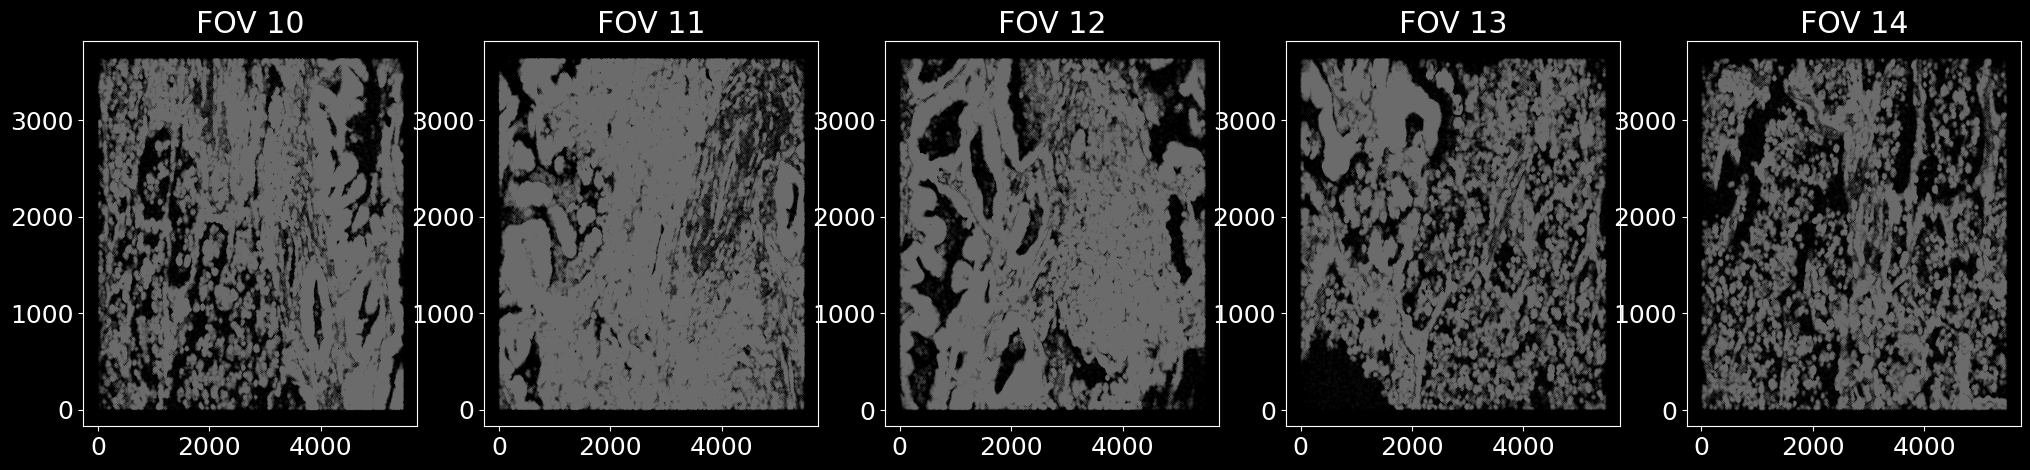

In [4]:
# we select 5 Field of Views (FOVs) from the NSCLC dataset as an example
fovs = [10, 11, 12, 13, 14]

fig, axes = plt.subplots(1, len(fovs), figsize = (len(fovs) * 5, 5))
for fov in fovs:
    df_spots_fov = pd.read_csv(f'../data/spots_cosmx_nsclc_he_et_al_fov_{fov}.txt', sep = '\t', header = 0, index_col = 0)
    df_spots_fov['fov'] = fov 

    axes[fov-10].scatter(df_spots_fov['x'], df_spots_fov['y'], s = 3e-4, c = 'gray')
    axes[fov-10].set_title(f'FOV {fov}')

    if fov == 10:
        df_spots_all = df_spots_fov.copy()
    else:
        df_spots_all = pd.concat([df_spots_all, df_spots_fov], axis = 0)

plt.show()

### apply pre-trained model to FOVs

In [ ]:
df_results_all = pd.DataFrame()
for fov in fovs:
    print(f'Running segmentation for FOV {fov}')
    df_spots_fov = df_spots_all[df_spots_all['fov'] == fov].copy()
    df_spots_seg = df_spots_fov[df_spots_fov['labels'] != 'background'].copy()
    df_spots_unseg = df_spots_fov[df_spots_fov['labels'] == 'background'].copy()
    df_spots_unseg = df_spots_unseg.loc[:, np.setdiff1d(df_spots_unseg.columns, ['segmented', 'labels'])].copy()

    bg_fov = br.BrGraph(
        df_spots_seg = df_spots_seg, 
        df_spots_unseg = df_spots_unseg,
    )

    bg_fov.use_settings(bg_pretrained) # use the settings from the pretrained model

    br.tl.node_classification(bg_fov, bg_fov.spots_all.copy(), n_neighbors = 10)
    br.tl.cell_segmentation(bg_fov)
    df_results, adata_ensembl, adata_segmented = br.tl.cell_annotation(bg_fov)

    df_results.to_csv(f'../data/transfer_nsclc_fov_{fov}.txt', sep = '\t')
    adata_ensembl.write(f'../data/transfer_nsclc_fov_{fov}_ensembl.h5ad')

    df_results['fov'] = fov
    adata_ensembl.obs['fov'] = fov

    df_results_all = pd.concat([df_results_all, df_results], axis = 0)
    if fov == 10:
        adata_all = adata_ensembl.copy()
    else:
        adata_all = adata_all.concatenate(adata_ensembl, index_unique = None, join = 'outer')

### visualize segmentation results for each FOV

In [ ]:
def visualize_results(df_results, ax, legend = False):
    df_spots_seg = df_results[df_results['ensembled_labels'] != 'Unknown'].copy()
    df_spots_unseg = df_results[df_results['ensembled_labels'] == 'Unknown'].copy()

    # visualize the spots
    x, y = df_spots_seg['x'].values, df_spots_seg['y'].values
    cell_types = df_spots_seg['ensembled_labels'].values

    fig, ax = plt.subplots(figsize = (6, 6))
    for idx, cell_type in enumerate(np.unique(cell_types)):
        
        xc = x[np.where(cell_types == cell_type)[0]]
        yc = y[np.where(cell_types == cell_type)[0]]

        ax.scatter(xc, yc, s = 0.03, label = cell_type, color = np.random.rand(3,))

    xb, yb = df_spots_unseg['x'].values, df_spots_unseg['y'].values
    ax.scatter(xb, yb, color = '#DCDCDC', alpha = 0.2, s = 0.015, label = 'background')

    if legend:
        h, l = ax.get_legend_handles_labels()
        plt.legend(h, l, loc = 'upper right', fontsize = 8, markerscale = 15)

    return ax

In [ ]:
fig, axes = plt.subplots(1, len(fovs), figsize = (len(fovs) * 5, 5))
for fov in fovs:
    df_results_fov = df_results_all[df_results_all['fov'] == fov].copy()
    legend = False if fov != fovs[-1] else True

    axes[fov-10] = visualize_results(df_results_fov, axes[fov-10], legend = legend)

# adjust gap
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

### integrate single cell data

We combine Bering-segmented single cell data from 5 FOVs and then integrate them using Harmony. We then visualize how consistent the prediction results are across different FOVs.

In [ ]:
import scanpy as sc
import scanpy.external as sce

sc.pp.filter_cells(adata_all, min_counts = 10)
sc.pp.normalize_total(adata_all, target_sum = 1e3)
sc.pp.log1p(adata_all)
sc.pp.scale(adata_all)
sc.tl.pca(adata_all)
sce.pp.harmony_integrate(adata_all, key = 'fov') # harmony integration

adata_all.obsm['X_pca'] = adata_all.obsm['X_pca_harmony'].copy()
sc.pp.neighbors(adata_all, n_neighbors = 10)
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all)
adata_all.write('../data/transfer_nsclc_all.h5ad')

In [ ]:
for col in ['fov','predicted_labels','leiden','n_counts','n_genes']:
    sc.pl.umap(adata_all, color = col)